In [1]:
import pandas as pd
from datetime import datetime
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from skopt import BayesSearchCV

In [2]:
df = pd.read_csv('Sales_Data.csv')

In [3]:
df

,Date,Customer,SKU,Actual_Price,List_Price,Discount_Rate,Featured_SKU,Units_Sold
0,2023-07-01,8091,216418,88.3500,106.1625,0.17,0,73
1,2023-07-01,8091,216419,88.3500,105.4500,0.16,0,111
2,2023-07-01,8091,216425,133.2375,133.2375,0.00,0,17
3,2023-07-01,8091,216233,132.5250,132.5250,0.00,0,29
4,2023-07-01,8091,217390,142.5000,168.8625,0.16,0,51
...,...,...,...,...,...,...,...,...
150137,2023-11-07,9984,223245,206.6250,192.3750,-0.07,0,67
150138,2023-11-07,9984,223153,213.0375,213.0375,0.00,0,63
150139,2023-11-07,9984,245338,469.5375,469.5375,0.00,0,7
150140,2023-11-07,9984,547934,170.2875,170.2875,0.00,0,7


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].apply(lambda x: x.timestamp())

In [5]:
X = df.drop(columns = ['Units_Sold'])
y = df[['Units_Sold']]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [7]:
best_params = {
    'colsample_bytree': 0.5,
    'learning_rate': 0.12182583714621935,
    'max_depth': 15,
    'min_child_samples': 10,
    'n_estimators': 1000,
    'num_leaves': 32,
    'subsample': 0.5,
    'random_state': 0
}


In [8]:
model = LGBMRegressor(**best_params)
model.fit(X_train,y_train)

LGBMRegressor(colsample_bytree=0.5, learning_rate=0.12182583714621935,
              max_depth=15, min_child_samples=10, n_estimators=1000,
              num_leaves=32, random_state=0, subsample=0.5)

In [9]:
y_pred = model.predict(X_test)

## 모델 성능 측정

In [10]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [11]:
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 2217.8182475621
Mean Absolute Error (MAE): 19.12263362904277
R-squared (R2): 0.8459503644373128


## Feature Importance 확인

In [12]:
feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

         Feature  Importance
1       Customer        5733
3   Actual_Price        5524
5  Discount_Rate        5153
4     List_Price        5065
0           Date        4746
2            SKU        3566
6   Featured_SKU        1213


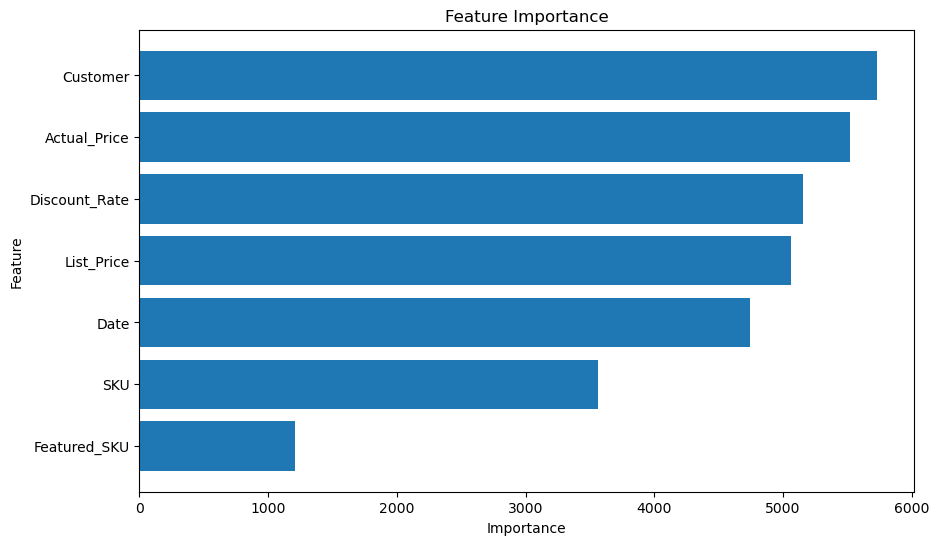

In [13]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

## 예측값과 실제 수요량과 비교를 위한 테이블 생성

In [14]:
df_test = pd.merge(X_test, y_test, left_index = True, right_index = True)

In [15]:
df_test['Date'] = pd.to_datetime(df_test['Date'], unit='s')

In [16]:
df_test['Prediction'] = y_pred

In [17]:
df_test = df_test.sort_index(ascending = True)

In [18]:
df_test['Prediction'] = df_test['Prediction'].astype('int')

In [19]:
df_test.head(5)

,Date,Customer,SKU,Actual_Price,List_Price,Discount_Rate,Featured_SKU,Units_Sold,Prediction
8,2023-07-01,8091,223153,213.0375,213.0375,0.0,0,18,13
12,2023-07-01,8095,219009,213.0375,213.0375,0.0,0,108,108
14,2023-07-01,8095,320485,205.9125,205.9125,0.0,0,34,32
16,2023-07-01,8095,222765,234.4125,234.4125,0.0,0,82,79
24,2023-07-01,8094,216425,129.6750,129.6750,0.0,0,31,31


## 현업 배포를 위한 모델 저장/불러오기

In [20]:
import joblib

joblib.dump(model, 'Sales Forecasting.pkl')

['Sales Forecasting.pkl']

In [21]:
import joblib
import pandas as pd

df = pd.read_csv("Promotion_Plan.csv")

loaded_model = joblib.load('Sales_Forecasting.pkl')

df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].apply(lambda x: x.timestamp())

predictions = loaded_model.predict(df)

df['Prediction'] = predictions

## BayesSearch 통한 하이퍼 파라미터 튜닝

In [22]:
param_space = {
    'num_leaves': (20, 50),
    'max_depth': (5, 15),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'n_estimators': (100, 1000),
    'min_child_samples': (10, 100),
    'subsample': (0.5, 1.0, 'uniform'),
    'colsample_bytree': (0.5, 1.0, 'uniform')
}

In [23]:
opt = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=32,
    cv=3,
    n_jobs=-1,
    scoring='r2',
    random_state=0
)

In [24]:
opt.fit(X_train, y_train)

print("Best parameters found: ", opt.best_params_)

y_pred = opt.predict(X_test)
print("R² score: ", r2_score(y_test, y_pred))

Best parameters found:  OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.15290983639896633), ('max_depth', 15), ('min_child_samples', 10), ('n_estimators', 1000), ('num_leaves', 50), ('subsample', 0.5)])
R² score:  0.8471455082768066
